# **multiview-stitcher** in the browser

Load this notebook into [JupyterLite](https://jupyter.org/try-jupyter/lab/index.html) to use multiview-stitcher without installation.

In [1]:
import micropip
await micropip.install('dask-image', deps=False)
await micropip.install('multiview-stitcher', deps=False)
await micropip.install(["numpy>=1.18", "zarr", "xarray", "tifffile>=2022.7.28", "networkx", "tqdm", "matplotlib", "scikit-image", "Geometry3D-vendored ==0.3.0", "spatial_image ==0.3.0", "multiscale_spatial_image ==0.11.2", "ngff-zarr ==0.4.7"])


## Load data

Drag and drop files into the `data` folder in the left jupyter panel.

In [13]:
import tifffile, os

input_dir = 'data'
tiles = [tifffile.imread(os.path.join(input_dir, f))
             for f in sorted(os.listdir(input_dir))
                 if f.endswith('.tif') and 'fused' not in f]

print('Loaded %s tiles' % len(tiles))
print('First tile shape:', tiles[0].shape)

Loaded 2 tiles
First tile shape: (3, 512, 512)


### Indicate metadata

In [5]:
tile_translations = [
    {'y': 0, 'x': 0},
    {'y': 0, 'x': 410},
    {'y': 410, 'x': 0},
]

tile_scales = [{'y': 1, 'x': 1}] * len(tile_translations)

channels = ['GFP', 'RFP', 'YFP']

In [7]:
# create multiscale-spatial-image objects from tiles

import dask.array as da

from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import msi_utils, vis_utils

msims = []
for tile, tile_translation, tile_scale in zip(tiles, tile_translations, tile_scales):
    print(tile_translation, tile_scale)

    sim = si_utils.get_sim_from_array(
        tile,
        dims=['c', 'y', 'x'],
        scale=tile_scale,
        translation=tile_translation,
        transform_key='manual_metadata',
        c_coords=channels,
    )

    msim = msi_utils.get_msim_from_sim(sim, scale_factors=[])
    msims.append(msim)

# vis_utils.plot_positions(msims, transform_key='stage_metadata', use_positional_colors=False)

{'y': 0, 'x': 0} {'y': 1, 'x': 1}
{'y': 0, 'x': 410} {'y': 1, 'x': 1}


## Registration

In [8]:
from dask.diagnostics import ProgressBar
from multiview_stitcher import registration

params = registration.register(
    msims,
    reg_channel_index=channels.index('GFP'),
    transform_key='manual_metadata',
    new_transform_key='translation_registered',
    registration_binning={'y': 2, 'x': 2},
    plot_summary=False,
)

print('Obtained registration parameters:\n\n', params)

Obtained registration parameters:

 [<xarray.DataArray (t: 1, x_in: 3, x_out: 3)>
array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]])
Coordinates:
  * t        (t) int32 0
Dimensions without coordinates: x_in, x_out, <xarray.DataArray (t: 1, x_in: 3, x_out: 3)>
array([[[ 1. ,  0. ,  0. ],
        [ 0. ,  1. , 52.2],
        [ 0. ,  0. ,  1. ]]])
Coordinates:
  * t        (t) int32 0
Dimensions without coordinates: x_in, x_out]


## Fusion

In [10]:
from multiview_stitcher import fusion

fused_sim = fusion.fuse(
    [msi_utils.get_sim_from_msim(msim, scale='scale0') for msim in msims],
    transform_key='translation_registered',
    output_spacing={'y': 2, 'x': 2}, # can be increased for faster fusion
).compute()

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x923b3f8>)

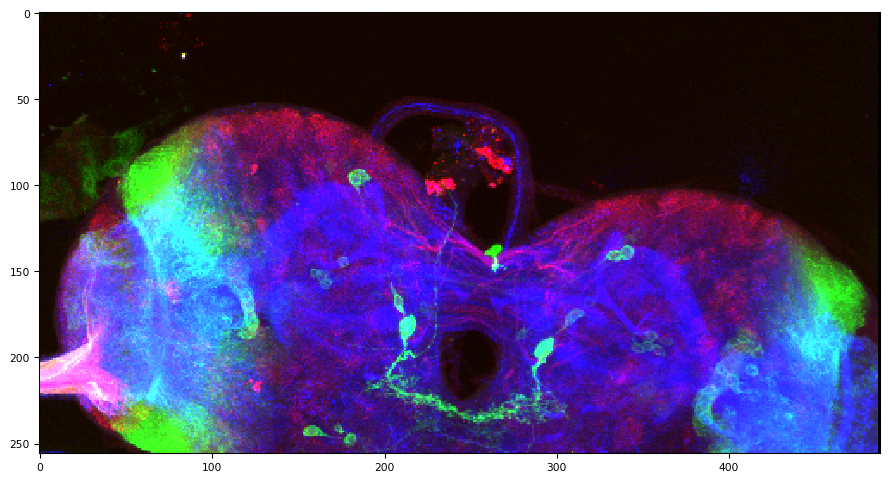

In [11]:
# visualize fusion

import tifffile
tifffile.imshow(fused_sim)

## Save fused output

The fused image will be saved into the data folder and can be downloaded using the jupyter panel on the left.

In [12]:
# save result to data folder
tifffile.imwrite('data/fused.tif', fused_sim)